In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### install detectron2 and dependency 

!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c00941441593563db87d46a82a3769fb6dcc64c0fa7da2ecdcdd47cd4e3575a8
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:16:06tcmalloc: large alloc 1147494400 bytes == 0x562fbe850000 @  0x7fe9403f1615 0x562f845cd3bc 0x562f846ae18a 0x562f845d01cd 0x562f846c2b3d 0x562f84644458 0x562f8463f02f 0x562f845d1aba 0x562f846442c0 0x562f8463f02f 0x562f845d1aba 0x562f84640cd4 0x562f846c3986 0x562f84640350 0x562f846c3986 0x562f84640350 0x562f846c3986 0x562f84640350 0x562f845d1f19 0x562f84615a79 0x56

In [4]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [5]:
# Some basic imports:
# Setup detectron2 logger
!pip -q install geopandas
import geopandas as gpd
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# tensorboard?
#%load_ext tensorboard
#%tensorboard --logdir output

# necessary libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import pdb

#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

     |████████████████████████████████| 1.0 MB 3.8 MB/s 
     |████████████████████████████████| 6.3 MB 62.0 MB/s 
     |████████████████████████████████| 16.7 MB 67.8 MB/s 


In [6]:
### The following two cells just determine that the setup is working correctly on a standard example.

# Get image, hash wget line if already downloaded.
# Just unhash if running this code for the first time, i.e. input.jpg has not yet been downloaded

!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")

# Create config
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

#cfg.merge_file = 'https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
#cfg.merge_from_file("./detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Here we just get the pre-trained weights straight from facebook hosting website

cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl'



# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

--2022-03-15 17:25:49--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.109.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.109.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K   358KB/s    in 0.6s    

2022-03-15 17:25:50 (358 KB/s) - ‘input.jpg’ saved [209222/209222]



model_final_a3ec72.pkl: 254MB [00:13, 18.7MB/s]                           
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, paddin

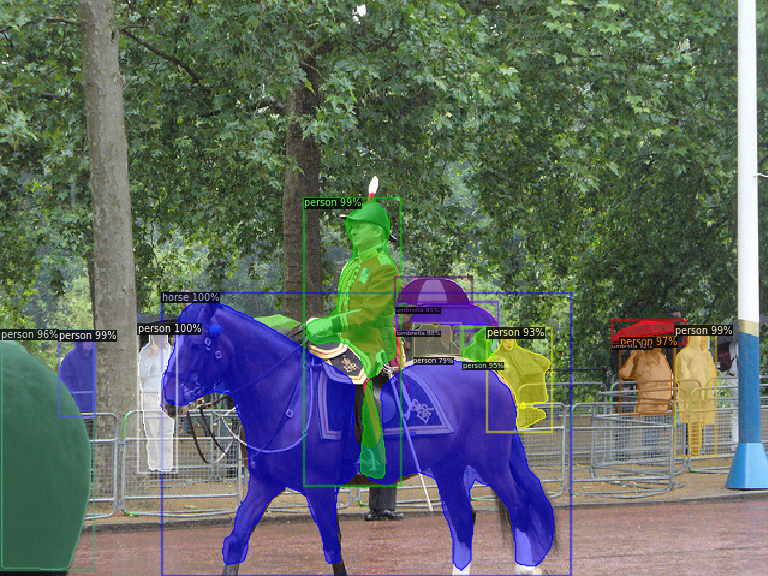

In [7]:
# Let's have a look
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

In [8]:
# Make sure the inevitable error messages are useful.
CUDA_LAUNCH_BLOCKING="1"

In [9]:
#### this loop builds the training dataset

def get_tree_dicts(directory):
    #filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/220303_AllSpLabelled.gpkg'
    #datagpd = gpd.read_file(filepath)
    #List_Genus = datagpd.Genus_Species.to_list()
    #Genus_Species_UniqueList = list(set(List_Genus))

    #list_of_classes = ['Pradosia_cochlearia','Eperua_falcata','Dicorynia_guianensis','Eschweilera_sagotiana','Eperua_grandiflora','Symphonia_sp.1','Sextonia_rubra','Vouacapoua_americana','Sterculia_pruriens','Tapura_capitulifera','Pouteria_eugeniifolia','Recordoxylon_speciosum','Chrysophyllum_prieurii','Platonia_insignis','Chrysophyllum_pomiferum','Parkia_nitida','Goupia_glabra','Carapa_surinamensis','Licania_alba','Bocoa_prouacensis','Lueheopsis_rugosa']
    #classes = list_of_classes
    classes = ['tree']
    #classes = Genus_Species_UniqueList #['tree'] # genus_species list
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.geojson')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)
        
        
        
        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        # Make sure we have the correct height and width
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = filename[0:400]
        print(filename[0:400])
            
        

        objs = []
        for features in img_anns['features']:
            anno = features['geometry']
            #pdb.set_trace()
            GenusSpecies = features['properties']['Genus_Species']
            #print("##### HERE IS AN ANNO #####", anno)...weirdly sometimes (but not always) have to make 1000 into a np.array
            px = [a[0] for a in anno['coordinates'][0]]
            py = [np.array(height) - a[1] for a in anno['coordinates'][0]]
            #print("### HERE IS PY ###", py)
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            #print("#### HERE ARE SOME POLYS #####", poly)
            obj = {
                   "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                   "bbox_mode": BoxMode.XYXY_ABS,
                   "segmentation": [poly],
                   "category_id": 0, #classes.index(features['properties']['Genus_Species']),  #id
                   "iscrowd": 0
                   }
            #pdb.set_trace()
            objs.append(obj)
            # print("#### HERE IS OBJS #####", objs)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


#filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/220303_AllSpLabelled.gpkg'
#datagpd1 = gpd.read_file(filepath)
#List_Genus = datagpd1.Genus_Species.to_list()#
#Genus_Species_UniqueList = list(set(List_Genus))
#list_of_classes = ['Pradosia_cochlearia','Eperua_falcata','Dicorynia_guianensis','Eschweilera_sagotiana','Eperua_grandiflora','Symphonia_sp.1','Sextonia_rubra','Vouacapoua_americana','Sterculia_pruriens','Tapura_capitulifera','Pouteria_eugeniifolia','Recordoxylon_speciosum','Chrysophyllum_prieurii','Platonia_insignis','Chrysophyllum_pomiferum','Parkia_nitida','Goupia_glabra','Carapa_surinamensis','Licania_alba','Bocoa_prouacensis','Lueheopsis_rugosa']

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("trees_" + d, lambda d=d: get_tree_dicts('/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/ForTrainingSegmentation/' + d))
    MetadataCatalog.get("trees_" + d).set(thing_classes=['tree'])     #list_of_classes)
trees_metadata = MetadataCatalog.get("trees_train")

In [ ]:
#dataset_dicts = get_tree_dicts("/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/ForTrainingTreeSpecies#/train")
#dataset_dicts

/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/ForTrainingTreeSpecies/train/tile_286400_583762.png
> <ipython-input-8-3e89493e035e>(35)get_tree_dicts()
-> GenusSpecies = features['properties']['Genus_Species']
(Pdb) exit


BdbQuit: ignored

In [10]:
# Let's look at our training image and annos for our geojson sepilok dataset!!!

dataset_dicts = get_tree_dicts("/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/ForTrainingSegmentation/train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=trees_metadata, scale=0.4)
    out = visualizer.draw_dataset_dict(d)
    image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    #display(Image.fromarray(img))
    display(Image.fromarray(image))

Output hidden; open in https://colab.research.google.com to view.

In [11]:
### Setup the evaluator

from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [12]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
import detectron2.utils.comm as comm
#import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
# just setting up the cfg file...these treaining parameters don't matter in this cell as they are overwritten below

#from detectron2.engine import DefaultTrainer
#from detectron2.config import get_cfg

#cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
#cfg.DATASETS.TRAIN = ("trees_train",)
#cfg.DATASETS.TEST = ("trees_test",)
#cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
#cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.BASE_LR = 0.00025
#cfg.SOLVER.MAX_ITER = 900
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("eval_2", exist_ok=True)
            output_folder = "eval_2"
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=[T.Resize((800, 800)), T.RandomBrightness(0.8, 1.8), 
        T.RandomContrast(0.6, 1.3), T.RandomSaturation(0.8, 1.4), T.RandomRotation(angle=[90, 90], expand=False), T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True)]))

In [14]:
# Train! Can change hyperparameters e.g. learning rate

import logging

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trees_train",)
cfg.DATASETS.TEST = ("trees_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# load our pre-trained model if you like

#cfg.MODEL.WEIGHTS = '/content/drive/Shareddrives/detectreeRGB/weights/model_final.pth'

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003
cfg.SOLVER.MAX_ITER = 900
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

### From here is the important bit that hasn't been repeated further up
cfg.TEST.EVAL_PERIOD = 100

# make clear where the output file each time

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#eval_results = inference_on_dataset(trainer.model, val_loader, DatasetEvaluators(evaluator))


#trainer.test(cfg, trainer.model, evaluator)



[03/15 17:30:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/15 17:32:10 d2.engine.train_loop]: Starting training from iteration 0
[03/15 17:32:20 d2.utils.events]:  eta: 0:06:38  iter: 19  total_loss: 1.977  loss_cls: 0.6335  loss_box_reg: 0.09196  loss_mask: 0.6916  loss_rpn_cls: 0.5113  loss_rpn_loc: 0.05774  time: 0.4681  data_time: 0.1208  lr: 6.627e-06  max_mem: 3315M
[03/15 17:32:29 d2.utils.events]:  eta: 0:06:28  iter: 39  total_loss: 1.686  loss_cls: 0.5216  loss_box_reg: 0.1386  loss_mask: 0.6881  loss_rpn_cls: 0.273  loss_rpn_loc: 0.05232  time: 0.4572  data_time: 0.0739  lr: 1.3287e-05  max_mem: 3315M
[03/15 17:32:38 d2.utils.events]:  eta: 0:06:19  iter: 59  total_loss: 1.525  loss_cls: 0.4061  loss_box_reg: 0.1945  loss_mask: 0.6803  loss_rpn_cls: 0.1367  loss_rpn_loc: 0.06069  time: 0.4542  data_time: 0.0603  lr: 1.9947e-05  max_mem: 3315M
[03/15 17:32:47 d2.utils.events]:  eta: 0:06:11  iter: 79  total_loss: 1.378  loss_cls: 0.3064  loss_box_reg: 0.1728  loss_mask: 0.6656  loss_rpn_cls: 0.1372  loss_rpn_loc: 0.04568  time: 0

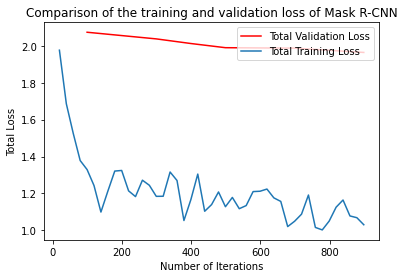

In [15]:
### Plot training and validation loss on the same plot to check how the training has gone

import json
import matplotlib.pyplot as plt

experiment_folder = '/content/output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x], label='Total Validation Loss', color='red')
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x], label='Total Training Loss')

plt.legend(loc='upper right')
plt.title('Comparison of the training and validation loss of Mask R-CNN')
plt.ylabel('Total Loss')
plt.xlabel('Number of Iterations')
plt.show()

In [16]:
# Setup to predict on new images, here setting up for the trees_test dataset, but can also use this setup
# for predicting on individual images as seen 2 cells down

from detectron2.utils.visualizer import ColorMode

# Weights automatically saved to OUTPUT_DIR + model_final.pth following training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  




# threshold confidence for predicted trees
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15
cfg.DATASETS.TEST = ("trees_test",)
predictor = DefaultPredictor(cfg)

In [17]:
# Let's look at our predictions on our test dataset!

dataset_dicts = get_tree_dicts("/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/ForTrainingTreeSpecies/test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=trees_metadata, scale=0.7, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    display(Image.fromarray(image))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip -q install rasterio
!pip -q install fiona
!pip -q install geopandas

# import geospatial libraries
import rasterio
from rasterio.transform import from_origin
import rasterio.features

import fiona

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon



     |████████████████████████████████| 19.3 MB 386 kB/s 
     |████████████████████████████████| 15.4 MB 4.2 MB/s 
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 73.4 MB/s 


In [ ]:
# Run first few cells first to import all required libraries
filepath = '/content/drive/MyDrive/Data/220117_AllSpLabelled.gpkg'



In [ ]:
!pip -q install geopandas
import geopandas as gpd
data = gpd.read_file(filepath)
List_Genus = data.Genus_Species.to_list()
print(data.Genus_Species, "\n")

#Need to filter out Indet. (200 or so Indet.)
sr = pd.Series(data.Genus_Species)
print(sr.value_counts()[0:20], "\n")

Countunqvalues = data["Genus_Species"].nunique()
print(Countunqvalues)

0       Recordoxylon_speciosum
1             Licaria_cannella
2                 Qualea_rosea
3           Sterculia_pruriens
4                 Qualea_rosea
                 ...          
3202     Pouteria_eugeniifolia
3203            Inga_loubryana
3204     Pouteria_eugeniifolia
3205       Tachigali_melinonii
3206       Tapura_capitulifera
Name: Genus_Species, Length: 3207, dtype: object 

Pradosia_cochlearia       246
Qualea_rosea              228
Eschweilera_sagotiana     171
Eperua_falcata            160
Dicorynia_guianensis      146
Eperua_grandiflora         95
Recordoxylon_speciosum     83
Tachigali_melinonii        68
Goupia_glabra              62
Vouacapoua_americana       61
Couratari_multiflora       56
Licania_alba               54
Symphonia_sp.1             52
Sextonia_rubra             45
Tapura_capitulifera        40
Eschweilera_coriacea       39
Jacaranda_copaia           38
Licania_ovalifolia         35
Licania_membranacea        34
Sterculia_pruriens         34
Name: Ge

In [ ]:
List_Genus
data = gpd.read_file(filepath)
List_Genus = data.Genus_Species.to_list()
Genus_Species_UniqueList = list(set(List_Genus))


['Parkia_ulei',
 'Pouteria_flavilatex',
 'Inga_thibaudiana',
 'Brosimum_rubescens',
 'Monteverdia_oblongata',
 'Pouteria_ambelaniifolia',
 'Pouteria_engleri',
 'Eriotheca_globosa',
 'Parkia_nitida',
 'Mabea_Indet.',
 'Chrysophyllum_prieurii',
 'Parinari_rodolphii',
 'Dipteryx_Indet.',
 'Chaunochiton_kappleri',
 'Chrysophyllum_argenteum',
 'Parkia_pendula',
 'Hieronyma_alchorneoides',
 'Mouriri_crassifolia',
 'Elaeoluma_nuda',
 'Eschweilera_congestiflora',
 'Ocotea_argyrophylla',
 'Inga_jenmanii',
 'Couratari_guianensis',
 'Pouteria_bilocularis',
 'Cecropia_sciadophylla',
 'Licaria_cannella',
 'Xylopia_Indet.',
 'Terminalia_aubletii',
 'Vatairea_erythrocarpa',
 'Perebea_rubra',
 'Enterolobium_schomburgkii',
 'Pouteria_singularis',
 'Mouriri_huberi',
 'Couratari_multiflora',
 'Eschweilera_sagotiana',
 'Bellucia_arborescens',
 'Tachigali_richardiana',
 'Eschweilera_coriacea',
 'Glycydendron_Indet.',
 'Sterculia_speciosa',
 'Apeiba_glabra',
 'Protium_Indet.',
 'Virola_surinamensis',
 'Agon

In [ ]:
#from detectron2.data.datasets import register_coco_instances
#register_coco_instances("YourTrainDatasetName", {},"path to train.json", "path to train image folder")
#register_coco_instances("YourTestDatasetName", {}, "path to test.json", "path to test image folder")